In [1]:
import os
os.chdir("E:\\Projects\\diffusion")
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
import numpy as np
from tqdm.auto import tqdm
from diffusers.utils import randn_tensor
from stadiff.models import SpaUNet1DModel
from stadiff import pipeline
import torch.nn.functional as F
from diffusers import DDPMScheduler
from collections import defaultdict
from torch_geometric.loader import NeighborLoader
from stadiff.vae import SpaAE
from stadiff import utils
from stadiff.dataset import TripletSampler
from scipy.spatial import cKDTree
from stadiff.analytics import mclust_R
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
sns.set_theme("paper", style="ticks", font_scale=1.25)
device = "cuda:0"

In [2]:
def get_rep(model, data, adata, add_key):
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm[add_key] = z.detach().cpu().numpy()
    return adata

def eval_model(model, data, adata, add_key):
    model.eval()
    with torch.no_grad():
        z, out = spa_ae(data.x, data.edge_index)
    adata.obsm[add_key] = z.detach().cpu().numpy()
    adata = utils.mclust_R(adata, 10, used_obsm=add_key, add_key=add_key + "_mclust", random_seed=2023)
    sc.pp.neighbors(adata, use_rep=add_key, n_neighbors=30)
    sc.tl.umap(adata, min_dist=0.5)
    sc.pl.umap(adata, color=[add_key + "_mclust"], ncols=1, frameon=False, wspace=0.4, use_raw=False)


def get_slice_loader(adata, data, batch_name, use_batch="slice_ID", batch_size=32, **kwargs):
    input_nodes = np.where(adata.obs[use_batch] == batch_name)[0]
    train_loader = NeighborLoader(data, num_neighbors=[5, 3], batch_size=batch_size,
                                  input_nodes=input_nodes, **kwargs)
    return train_loader

# Data preprocessing

In [3]:
adata = sc.read_h5ad("E:\Projects\diffusion\dataset\E16-18h_a_count_normal_stereoseq.h5ad")
batch_list = adata.obs["slice_ID"].unique().tolist()
used_batches = batch_list
adata = adata[adata.obs["slice_ID"].isin(used_batches)]
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# filter by highly
adata = adata[:, adata.var['highly_variable']]
print("Used batches", used_batches)

Used batches ['E16-18h_a_S01', 'E16-18h_a_S02', 'E16-18h_a_S03', 'E16-18h_a_S04', 'E16-18h_a_S05', 'E16-18h_a_S06', 'E16-18h_a_S07', 'E16-18h_a_S08', 'E16-18h_a_S09', 'E16-18h_a_S10', 'E16-18h_a_S11', 'E16-18h_a_S12', 'E16-18h_a_S13', 'E16-18h_a_S14']


In [4]:
iter_comb = [(used_batches[i], used_batches[i+1]) for i in range(len(used_batches)-1)]
adata = utils.cal_spatial_net3D(adata, iter_comb=None, batch_id="slice_ID", rad_cutoff=1.4, z_k_cutoff=3,
                                add_key="spatial_net")

------Calculating spatial network for each batch...
Calculating spatial network for batch E16-18h_a_S01...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3790 edges, 985 cells, 3.8477 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S02...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3718 edges, 965 cells, 3.8528 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S03...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3932 edges, 1021 cells, 3.8511 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S04...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 4594 edges, 1189 cells, 3.8638 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S05...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contai

In [5]:
spatial_data = adata.obsm["spatial"]
new_spatial_data = utils.quantize_coordination(spatial_data, [("binary_search", 0.3), ("binary_search", 0.3), ("division", 0.35)])
adata.obsm["spatial_new"] = new_spatial_data

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 2.284375, mean deviation is 0.10948528546915216
Quantize 1th dimension of spatial coordinates to 2.284375, mean deviation is 0.10946789253833569
Quantize 2th dimension of spatial coordinates to 2.857142857142857, mean deviation is 2.0671056927263024e-16


In [6]:
data = pipeline.prepare_dataset(adata, use_net="spatial_net", use_spatial="spatial_new", device=device)

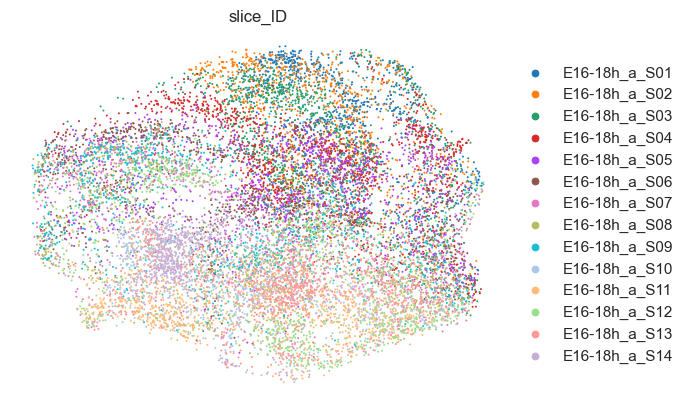

In [7]:
# perform PCA on the data
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(adata, color=["slice_ID"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

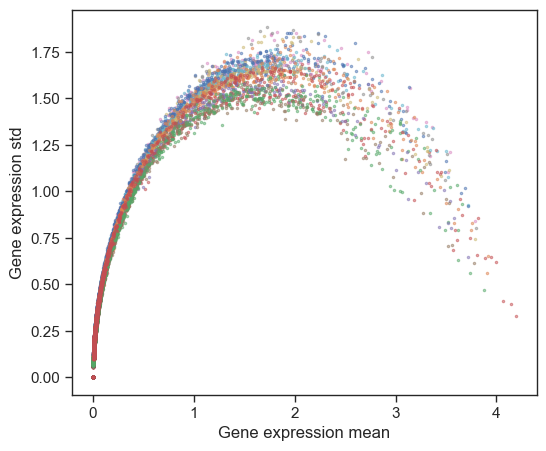

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for batch_name in used_batches:
    sub_adata = adata[adata.obs["slice_ID"]==batch_name]
    ax.scatter(sub_adata.X.mean(axis=0), sub_adata.X.std(axis=0), label=batch_name, alpha=0.5, s=3)
    ax.set_xlabel("Gene expression mean")
    ax.set_ylabel("Gene expression std")

# Training Models

In [8]:
# training autoencoder through each slice
model_config = {"pretrain_epochs": 500,
                "align_epochs": 500,
                "diffusion_epochs": 2000,
                "gradient_clip": 5,
                "save_dir": "E:\Projects\diffusion\output\Multi-slice-embryo"}

### Pretraining autencoder on each slice

In [9]:

model = SpaAE(input_dim=3000,
               block_list=["ResBlock"],
               gat_dim=[512, 32],
               block_out_dims=[32, 32]).to(device)
n_epochs = model_config["pretrain_epochs"]
train_loaders = [get_slice_loader(adata, data, used_batches[ind]) for ind in range(len(used_batches))]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
loss_list = []
pbar = tqdm(range(n_epochs))
model.train()
for epoch in range(1, n_epochs + 1):
    for train_loader in train_loaders:
        for batch in train_loader:
            optimizer.zero_grad()
            z, out = model(batch.x, batch.edge_index)
            loss = F.mse_loss(out, batch.x)
            loss_list.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
            loss_list.append(loss.item())
        scheduler.step()
    pbar.update(1)
torch.save(model, os.path.join(model_config["save_dir"], "spa_autoencoder.pth"))

  0%|          | 0/500 [00:00<?, ?it/s]

## Aligning the latent space by triplet loss

In [10]:
spa_ae = torch.load(os.path.join(model_config["save_dir"], "spa_autoencoder.pth"))

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


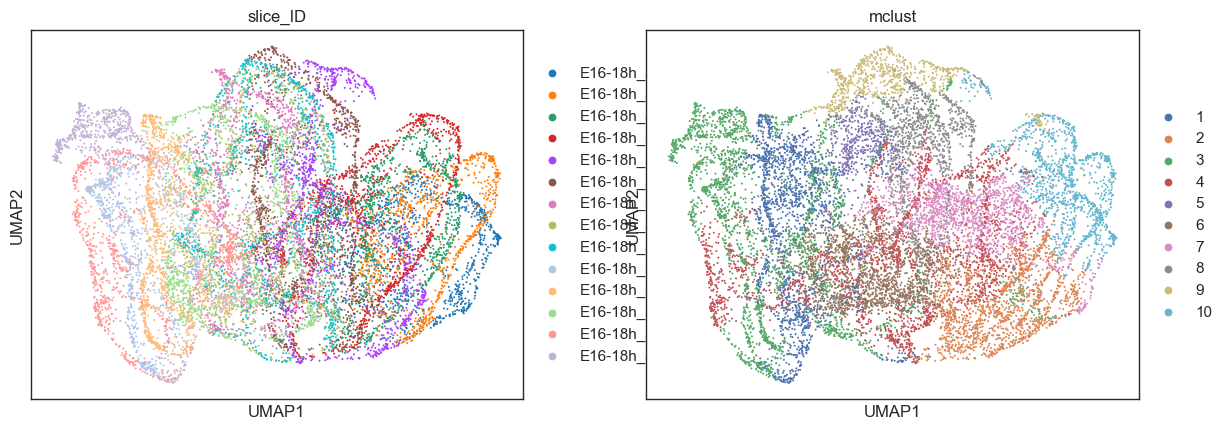

<Figure size 640x480 with 0 Axes>

In [11]:
with torch.no_grad():
    spa_ae.eval()
    with torch.no_grad():
        z, out = spa_ae(data.x, data.edge_index)
    adata.obsm["hidden_state"] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="hidden_state", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)
sub_adata = mclust_R(adata, 10, use_rep="hidden_state", add_key="mclust", random_seed=0, modelNames="VII")
sc.pl.umap(adata, color=["slice_ID", "mclust"])
plt.tight_layout()

In [12]:
train_loaders = []
index_mappings = []
iter_combs = [(i, i+1) for i in range(len(used_batches)-1)]
for batch_name in used_batches:
    num_spots = int((adata.obs["slice_ID"] == batch_name).values.sum())
    loader = get_slice_loader(adata, data, batch_name, batch_size=num_spots)
    train_loaders.append(loader)
    batch = next(iter(loader))
    index_mappings.append({val.item(): idx for idx, val in enumerate(batch.n_id)})

In [13]:
import torch.nn as nn
loss_list = []
n_epochs = model_config["align_epochs"]
pbar = tqdm(range(n_epochs))
optimizer = torch.optim.Adam(spa_ae.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
triplet_loss = nn.TripletMarginLoss(margin=1, p=2)
update_mnn_eval = 100

for epoch in range(1, n_epochs + 1):
    if epoch % update_mnn_eval == 1:
        # update the representation
        print("Updating the representation")
        adata = get_rep(spa_ae, data, adata, "hidden_state")
        tri_samplers = []
        for (target_id, ref_id) in iter_combs:
            tri_samplers.append(TripletSampler(adata, data, target=used_batches[target_id],
                                               use_rep="hidden_state",
                                               reference=used_batches[ref_id],
                                               use_batch="slice_ID",
                                               num_neighbors=15))
    for ind, (target_id, ref_id) in enumerate(iter_combs):
        optimizer.zero_grad()
        target_batch = next(iter(train_loaders[target_id]))
        reference_batch = next(iter(train_loaders[ref_id]))
        z_target, out_target = spa_ae(target_batch.x, target_batch.edge_index)
        z_reference, out_reference = spa_ae(reference_batch.x, reference_batch.edge_index)
        anchor_indices, positive_indices, negative_indices = tri_samplers[ind].query(target_batch.n_id.detach().cpu().numpy())
        anchor_indices = [index_mappings[target_id][i] for i in anchor_indices]
        positive_indices =  [index_mappings[ref_id][i] for i in positive_indices]
        negative_indices = [index_mappings[target_id][i] for i in negative_indices]
        loss_rmse = F.mse_loss(out_target, target_batch.x) * .5 + F.mse_loss(out_reference, reference_batch.x) * .5
        z_a = z_target[anchor_indices]
        z_p = z_reference[positive_indices]
        z_n = z_target[negative_indices]
        loss_tri = triplet_loss(z_a, z_p, z_n)
        loss = loss_tri + loss_rmse
        loss.backward()
        torch.nn.utils.clip_grad_norm_(spa_ae.parameters(), 5)
        optimizer.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
        loss_list.append(loss.item())
        scheduler.step()
    pbar.update(1)
torch.save(spa_ae, os.path.join(model_config["save_dir"], "spa_autoencoder_aligned.pth"))

  0%|          | 0/500 [00:00<?, ?it/s]

Updating the representation
Updating the representation
Updating the representation
Updating the representation
Updating the representation


## Training the denoise model

In [14]:
def evaluate(adata, data, noise_scheduler, model, save_folder=None,
             prefix=None,
             plot_slice_ids = None,
             cluster_method="leiden",
             cluster_params=0.55):
    denoised = randn_tensor(data.x.shape, device=data.x.device)
    denoised = denoised.unsqueeze(1)
    with torch.no_grad():
        for t in noise_scheduler.timesteps:
            model_output = model(denoised, t, data.spatial).sample
            denoised = noise_scheduler.step(model_output, t, denoised).prev_sample
    denoised = denoised.squeeze(1)
    adata.obsm["simulated"] = denoised.cpu().numpy()
    sc.pp.neighbors(adata, use_rep="simulated", n_neighbors=30)
    sc.tl.umap(adata, min_dist=0.5)
    # perform leiden clustering
    if cluster_method == "leiden":
        sc.tl.leiden(adata, key_added="leiden", resolution=cluster_params)
    elif cluster_method == "mclust":
        adata = utils.mclust_R(adata, cluster_params,
                               used_obsm="simulated", add_key="mclust", random_seed=2023)
    else:
        raise NotImplementedError
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
    with plt.rc_context():
        fig, axes = plt.subplots(2, len(plot_slice_ids), figsize=(10, 6))
        for ind, batch_name in enumerate(plot_slice_ids):
            sub_adata = adata[adata.obs["slice_ID"] == batch_name, :].copy()
            sc.pl.umap(sub_adata, color=[cluster_method], ncols=1, frameon=False,
                   show=False, ax=axes[0][ind])
            axes[0][ind].set_title(batch_name)
            sc.pl.spatial(sub_adata, color=[cluster_method], ncols=1, frameon=False,
                          spot_size=1.15, show=False, ax=axes[1][ind])
            axes[1][ind].set_title("")
        plt.savefig(os.path.join(save_folder, "embedding-{}_{}.png".format(prefix, cluster_method)))

In [15]:
adata = get_rep(spa_ae, data, adata, "hidden_state")
normalizer = utils.MinMaxNormalize(adata.obsm["hidden_state"], dim=0)
normalized_rep = normalizer.normalize(adata.obsm["hidden_state"])
adata.obsm["n_hidden_state"] = normalized_rep

  0%|          | 0/2000 [00:00<?, ?it/s]

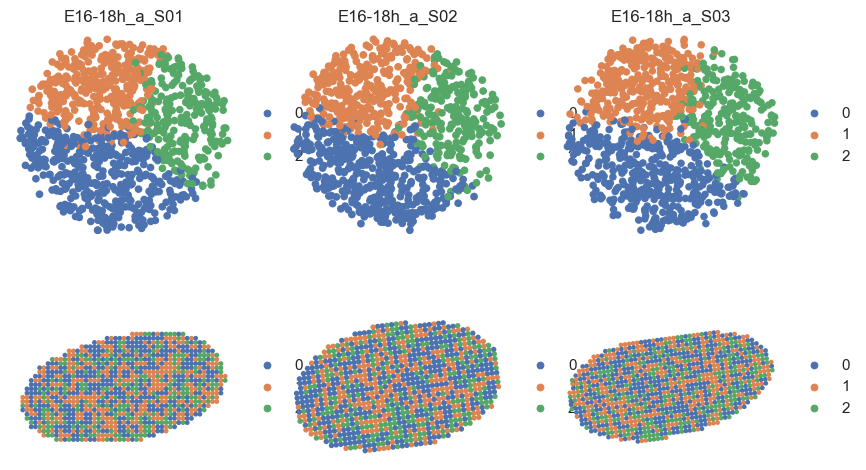

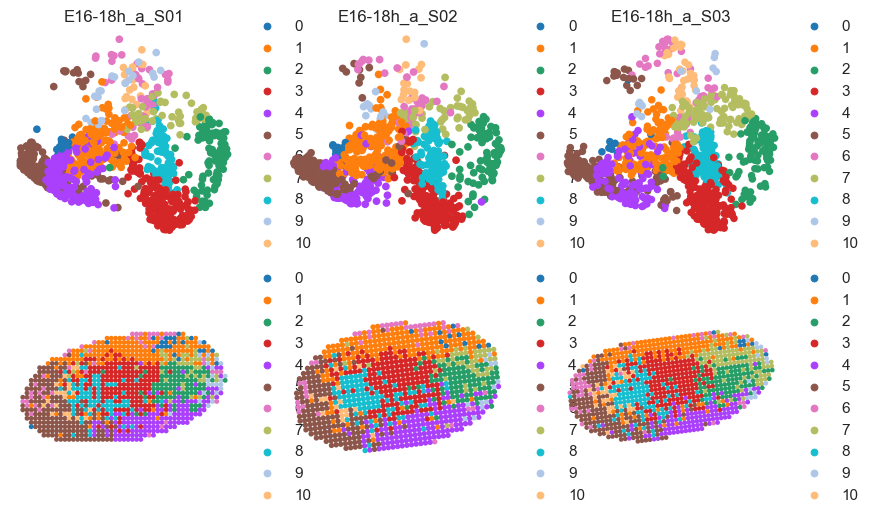

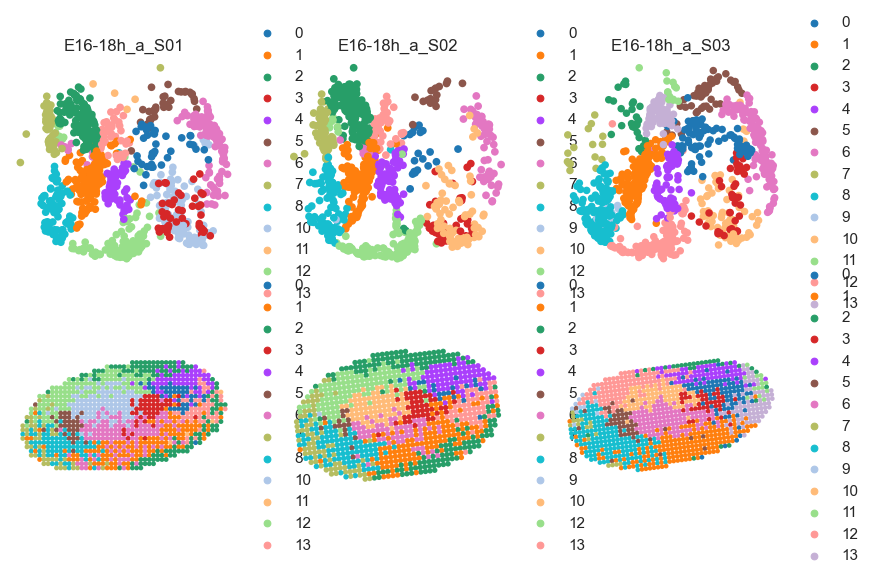

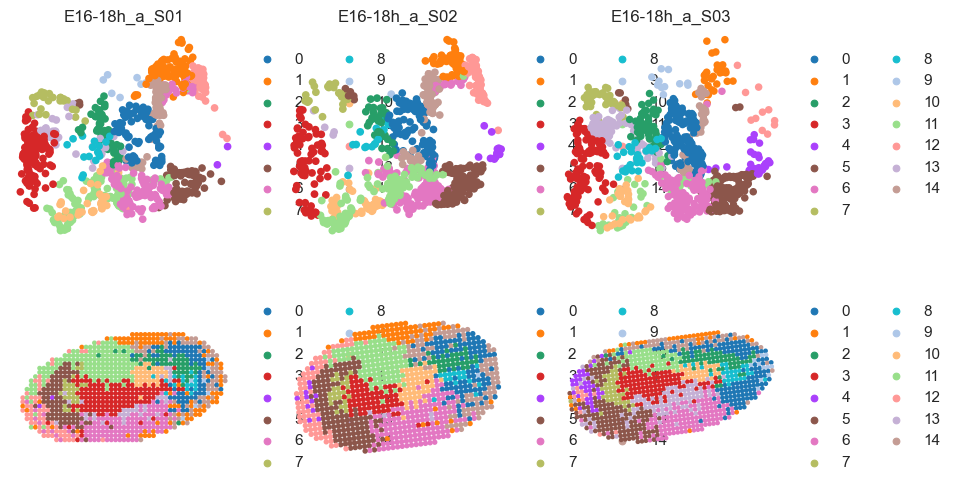

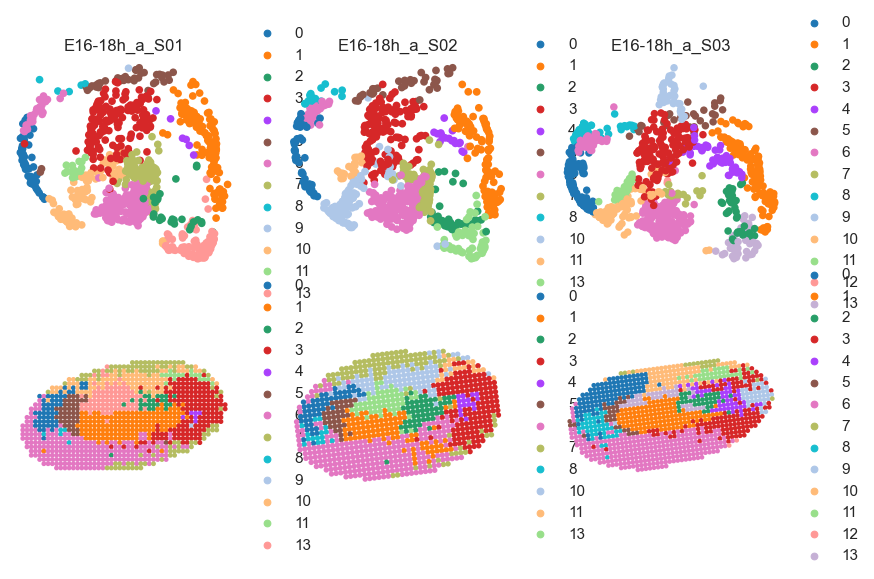

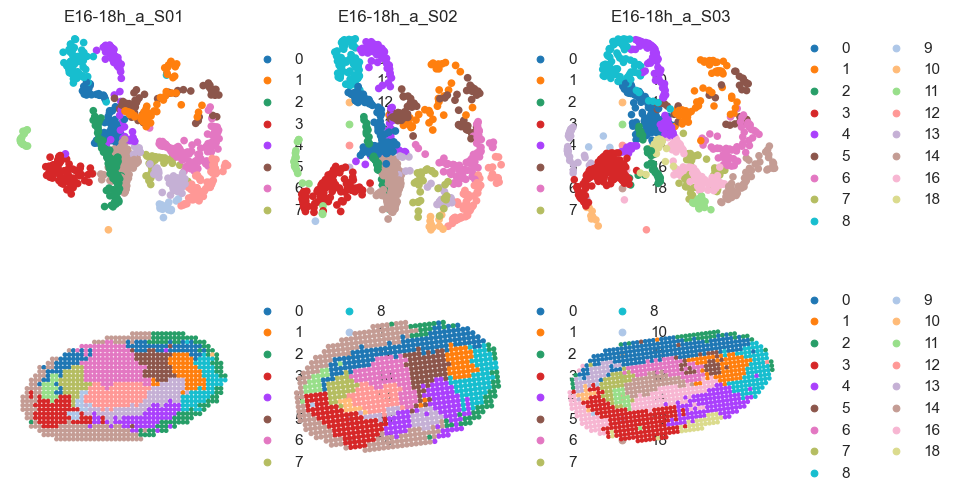

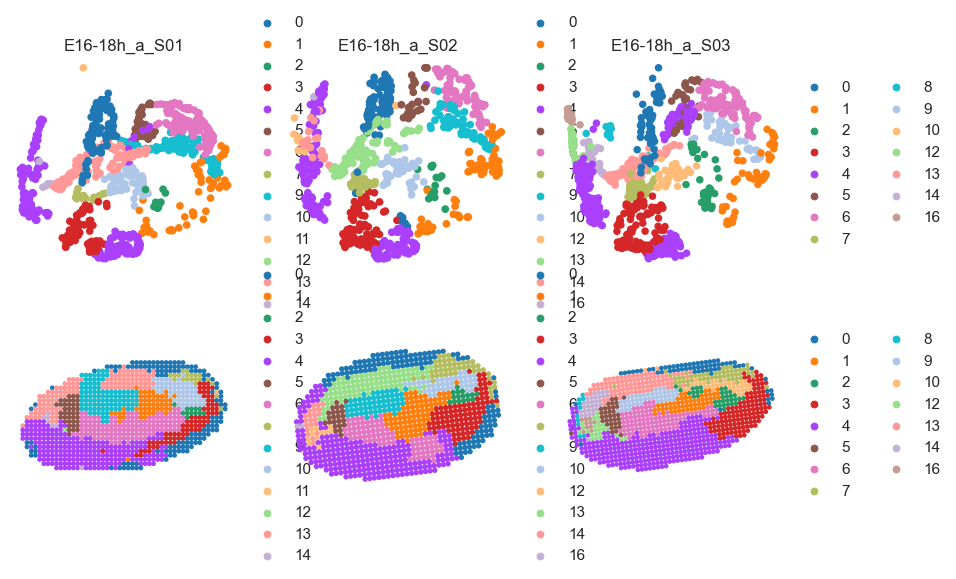

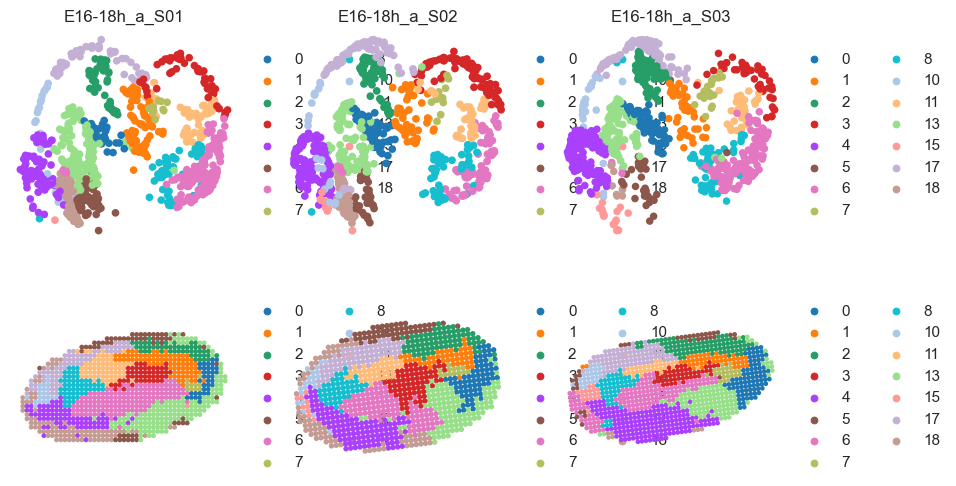

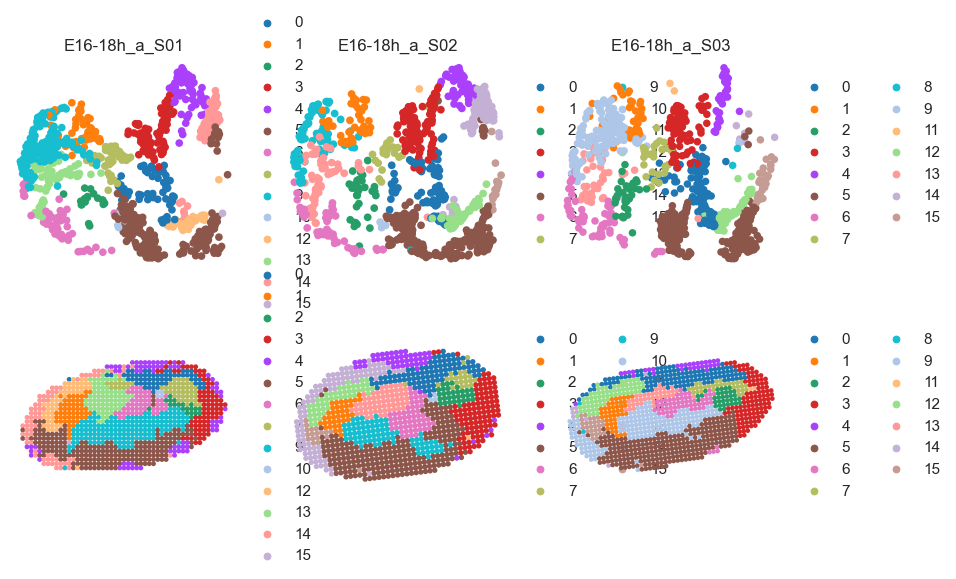

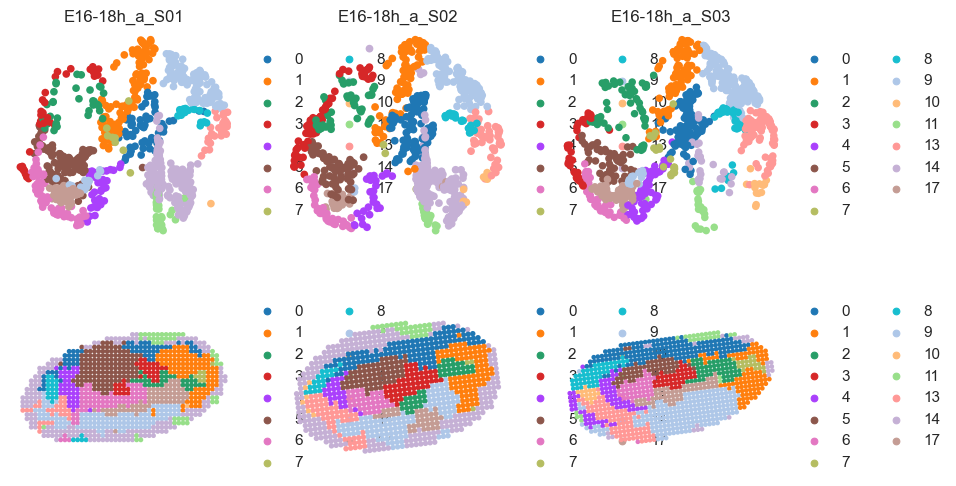

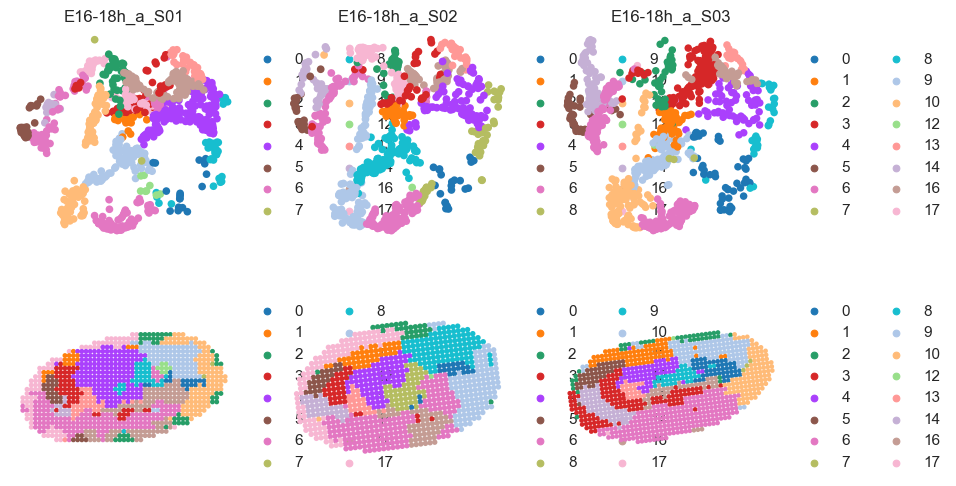

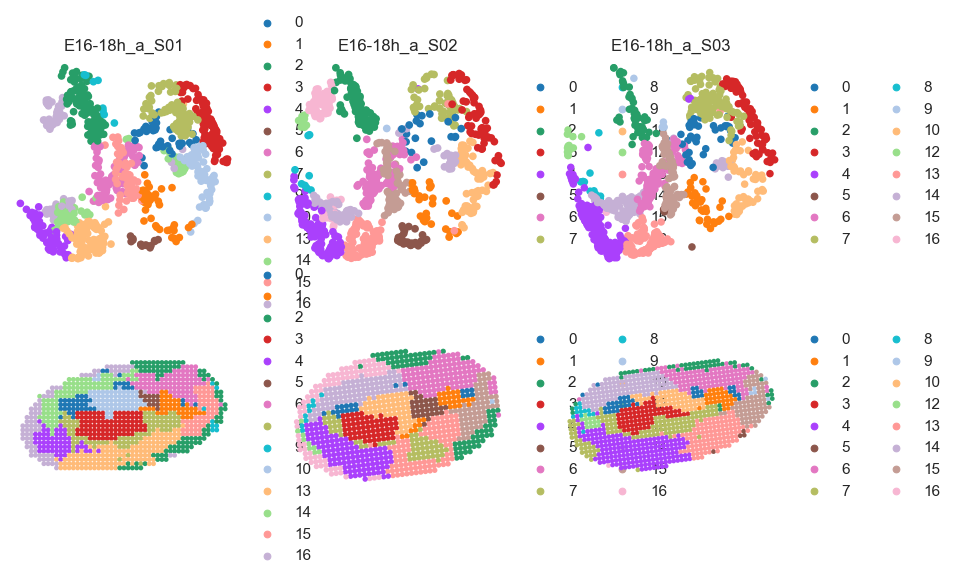

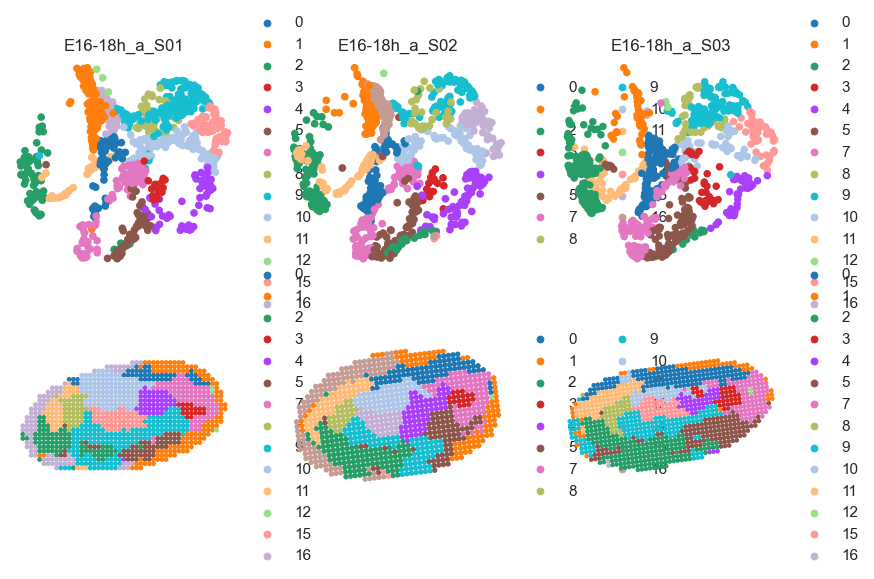

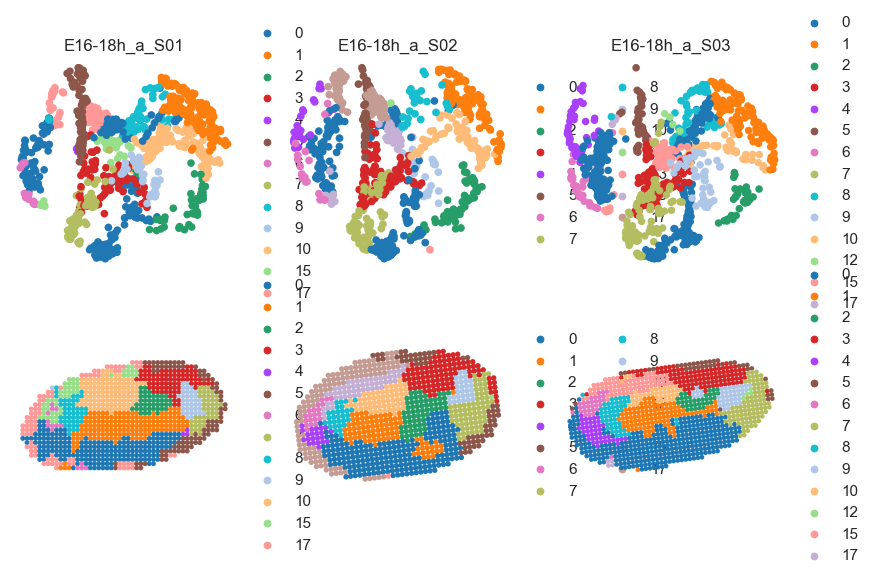

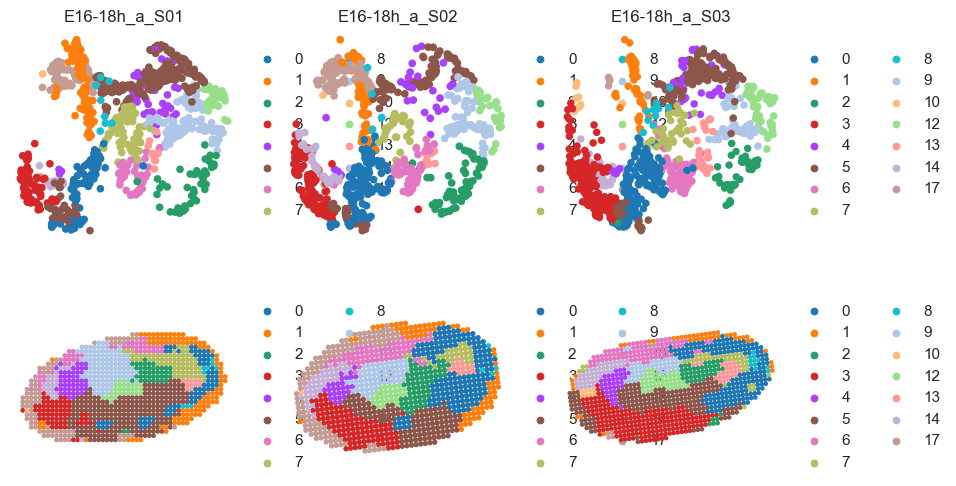

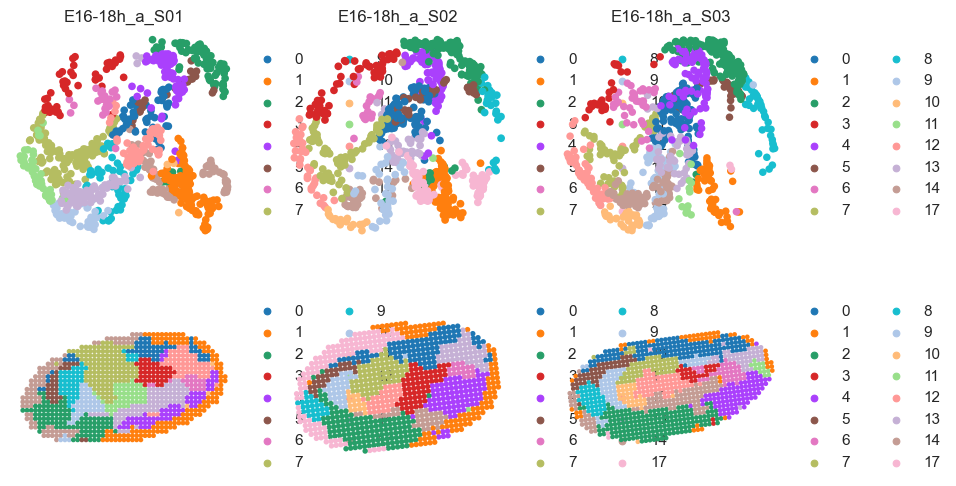

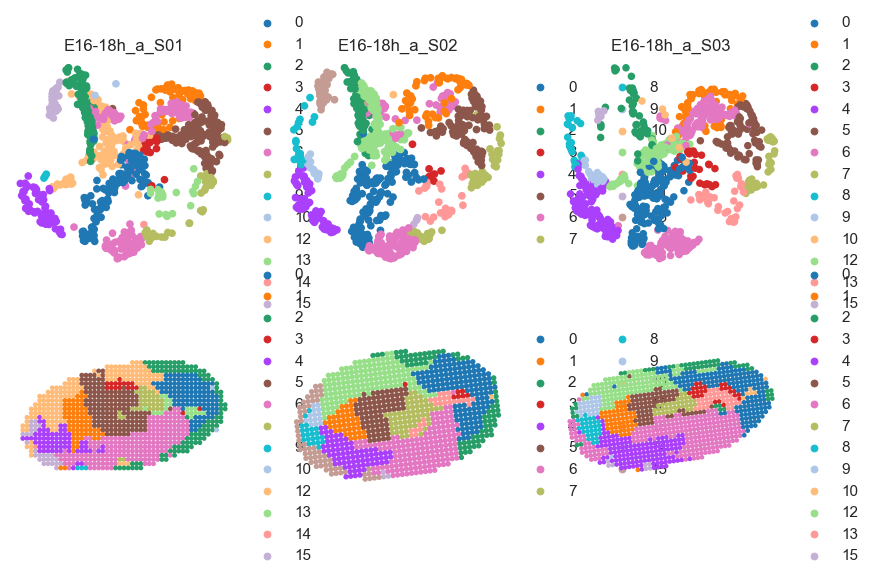

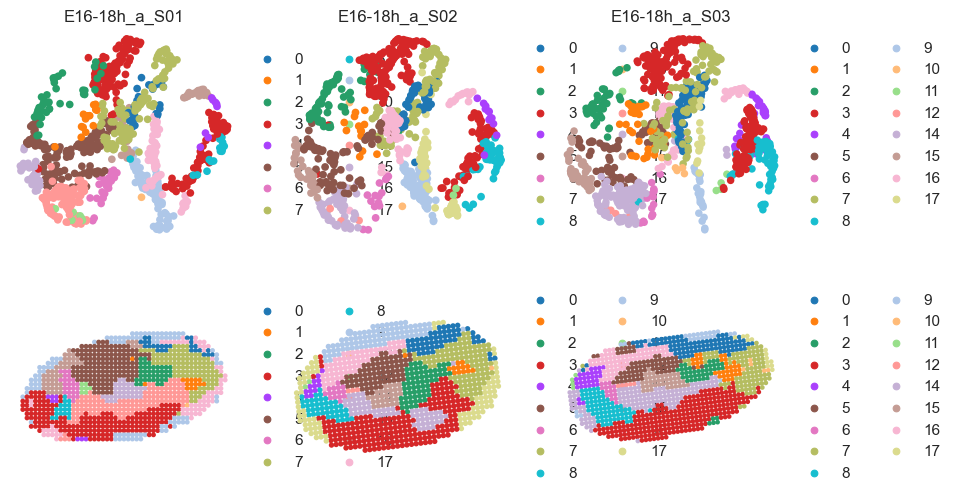

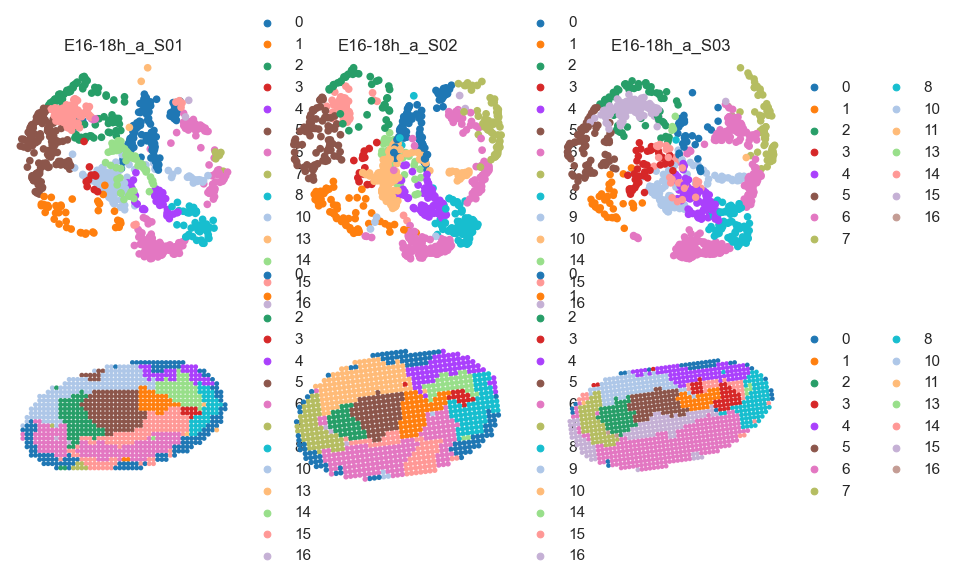

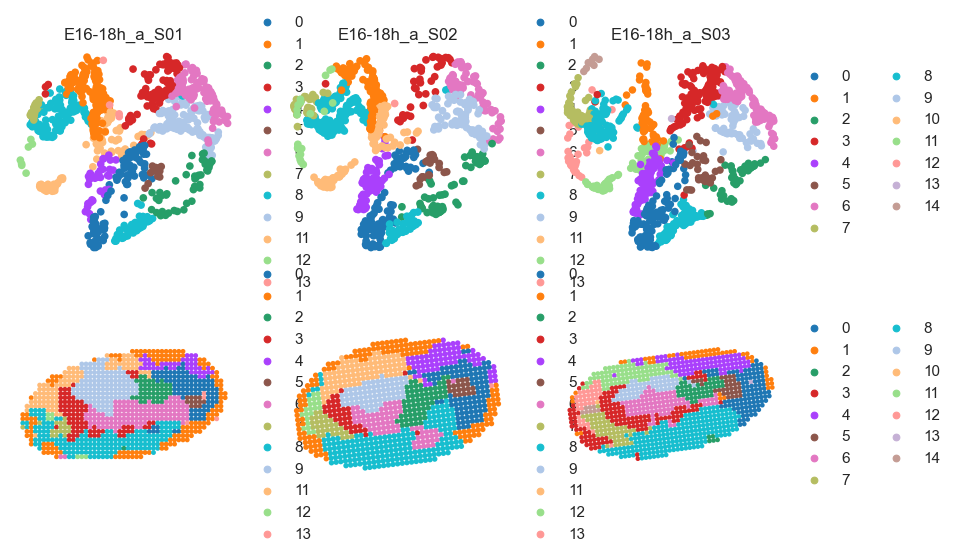

In [16]:
n_epochs = model_config["diffusion_epochs"]
data = pipeline.prepare_dataset(adata, use_rep="n_hidden_state", use_spatial='spatial_new').to(device)
denoise_net = SpaUNet1DModel(in_channels=18, out_channels=1, spatial_encoding="sinusoidal3d").to(device)
optimizer = torch.optim.AdamW(denoise_net.parameters(), lr=1e-4, weight_decay=1e-6)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(denoise_net.parameters(), lr=1e-4, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
pbar = tqdm(range(n_epochs))
evaluate_interval = 100
logging = defaultdict(list)
loader = NeighborLoader(data, num_neighbors=[5, 3],
                        batch_size=64,)
for epoch in range(1, n_epochs+1):
    for batch_id, batch in enumerate(loader):
        clean_data = batch.x
        clean_data = clean_data.unsqueeze(1) # (batch_size, 1, num_channels)
        optimizer.zero_grad()
        noise = torch.randn_like(clean_data)
        timesteps = torch.randint(0, 1000, (clean_data.shape[0],), device=data.x.device, dtype=torch.long, )
        noisy_data = noise_scheduler.add_noise(clean_data, noise, timesteps)
        noise_pred = denoise_net(noisy_data, timesteps, batch.spatial).sample
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        logging["loss"].append(loss.item())
        # clip gradient
        torch.nn.utils.clip_grad_norm_(denoise_net.parameters(), 5)
        optimizer.step()
        lr_scheduler.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}, batch_id: {batch_id}")
    if epoch % evaluate_interval == 1:
        evaluate(adata, data, noise_scheduler, denoise_net,
         save_folder=os.path.join(model_config["save_dir"], "figures"),
         prefix= str(epoch // 100) + "h",
         plot_slice_ids=used_batches[:3],
         cluster_method="leiden",
         cluster_params=0.55)
    pbar.update(1)
torch.save(denoise_net, os.path.join(model_config["save_dir"], "denoise_net.pth"))

In [17]:
torch.save(denoise_net, os.path.join(model_config["save_dir"], "denoise_net.pth"))

## Downstream analysis

In [7]:
from stadiff import analytics as an
data = pipeline.prepare_dataset(adata, use_rep=None, use_spatial='spatial_new').to(device)
spa_ae = torch.load("E:\Projects\diffusion\output\Multi-slice-embryo\\spa_autoencoder_aligned.pth")
spa_ae.eval()
adata = get_rep(spa_ae, data, adata, "aligned_hidden_state")
# umap embedding
sc.pp.neighbors(adata, use_rep="aligned_hidden_state", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)
# perform leiden clustering

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


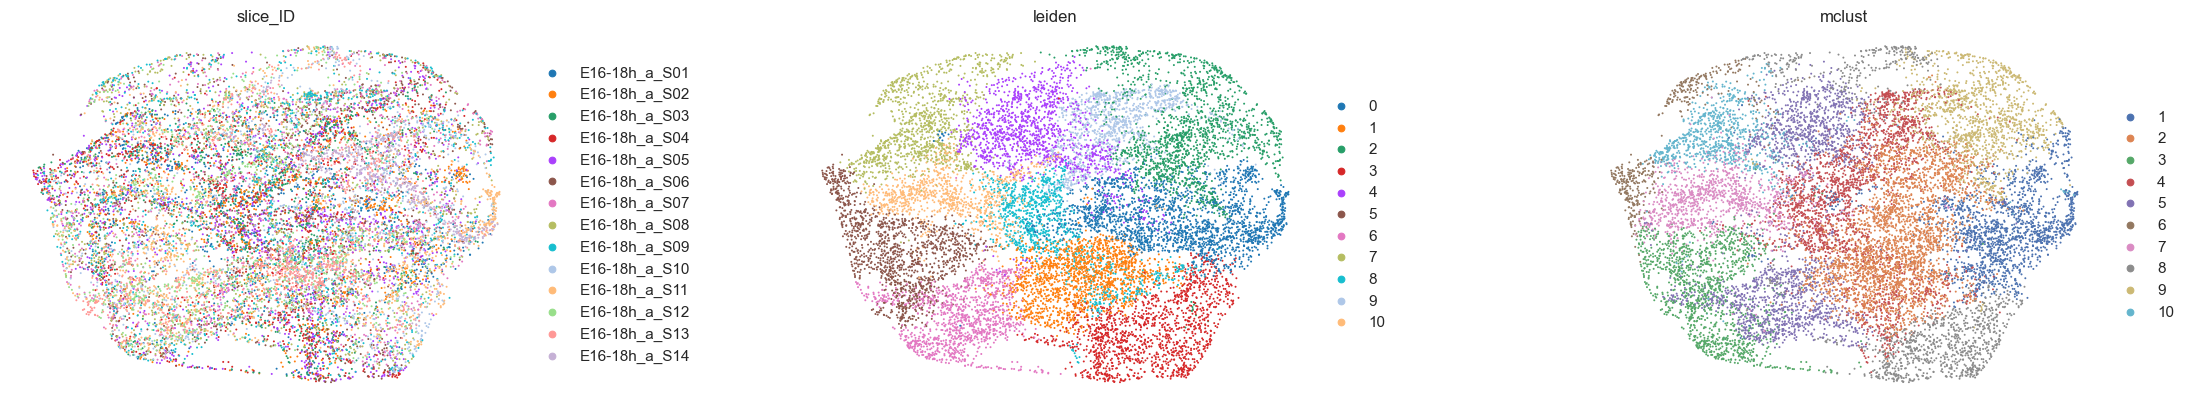

<Figure size 640x480 with 0 Axes>

In [13]:
sc.tl.leiden(adata, key_added="leiden", resolution=0.325)
adata = an.mclust_R(adata, 10, use_rep="aligned_hidden_state", add_key="mclust", random_seed=2023)
# visualize the results
sc.pl.umap(adata, color=["slice_ID", "leiden", "mclust"], ncols=3, frameon=False, wspace=0.4, use_raw=False)
plt.tight_layout()

In [14]:
normalizer = utils.MinMaxNormalize(adata.obsm["aligned_hidden_state"], dim=0)
normalized_rep = normalizer.normalize(adata.obsm["aligned_hidden_state"])
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [15]:
# load denoise net
denoise_net = torch.load("E:\Projects\diffusion\output\Multi-slice-embryo\\denoise_net.pth")
device = "cuda:0"
denoise_net = denoise_net.to(device)

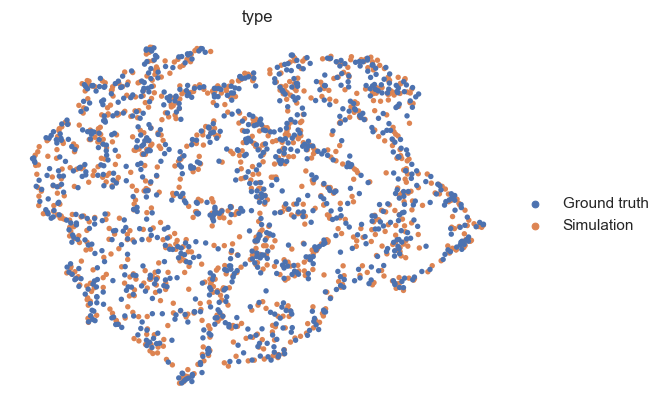

In [16]:
batch_id = 0
spatial = torch.from_numpy(adata.obsm["spatial_new"][adata.obs["slice_ID"] == used_batches[batch_id]])
# set spatial to int64
spatial[:, 2] = 0
spatial = spatial.type(torch.int64)
simulated = pipeline.simulate(spatial.to(device), noise_scheduler, denoise_net, n_spots=spatial.shape[0], p=32, device=device)
simulated = simulated.cpu().numpy()
simulated1 = normalizer.denormalize(simulated)
true_hidden_states = adata.obsm["aligned_hidden_state"][adata.obs["slice_ID"] == used_batches[batch_id]]
# concat simulated with true hidden states
comb_hidden_states = np.concatenate([simulated1, true_hidden_states], axis=0)
adata_comp = sc.AnnData(comb_hidden_states)
adata_comp.obs["type"] = ["Simulation"] * simulated1.shape[0] + ["Ground truth"] * true_hidden_states.shape[0]
# umap embedding
sc.pp.neighbors(adata_comp, use_rep="X", n_neighbors=30)
sc.tl.umap(adata_comp, min_dist=0.5)
# plot umap
sc.pl.umap(adata_comp, color=["type"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

In [20]:
simulated_list = []
for batch_name in used_batches:
    spatial = torch.from_numpy(adata.obsm["spatial_new"][adata.obs["slice_ID"] == batch_name])
    # set spatial to int64
    spatial = spatial.type(torch.int64)
    simulated = pipeline.simulate(spatial.to(device), noise_scheduler, denoise_net, n_spots=spatial.shape[0], p=32, device=device)
    simulated = simulated.cpu().numpy()
    simulated = normalizer.denormalize(simulated)
    simulated_list.append(simulated)
simulated = np.concatenate(simulated_list, axis=0)
adata.obsm["simulated"] = simulated

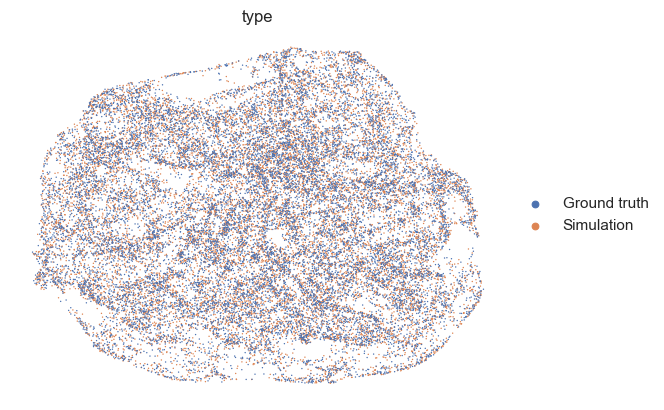

In [21]:
# crate a adata that concatenates the simulated and true hidden states
true_hidden_states = adata.obsm["aligned_hidden_state"]
comb_hidden_states = np.concatenate([simulated, true_hidden_states], axis=0)
adata_comp = sc.AnnData(comb_hidden_states)
adata_comp.obs["type"] = ["Simulation"] * simulated.shape[0] + ["Ground truth"] * true_hidden_states.shape[0]
# umap embedding
sc.pp.neighbors(adata_comp, use_rep="X", n_neighbors=30)
sc.tl.umap(adata_comp, min_dist=0.5)
# plot umap
sc.pl.umap(adata_comp, color=["type"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

In [37]:
batch_id = 0
batch_name1 = used_batches[batch_id]
batch_name2 = used_batches[batch_id+1]
spatial1 = torch.from_numpy(adata.obsm["spatial_new"][adata.obs["slice_ID"] == batch_name1])
spatial2 = torch.from_numpy(adata.obsm["spatial_new"][adata.obs["slice_ID"] == batch_name2])
# set spatial to int64
spatial1 = spatial1.type(torch.int64)
spatial2 = spatial2.type(torch.int64)
spatial_imputed = spatial1
spatial_imputed[:, 2] = 1

In [35]:
spatial_imputed = spatial_imputed.to(device)
simulated = pipeline.simulate(spatial_imputed, noise_scheduler, denoise_net, n_spots=spatial_imputed.shape[0], p=32, device=device)
simulated = simulated.cpu().numpy()
simulated = normalizer.denormalize(simulated)

In [45]:
# crate a adata that concatenates the simulated and true hidden states
true_hidden_states = adata.obsm["aligned_hidden_state"][adata.obs["slice_ID"].isin([batch_name1, batch_name2])]
comb_hidden_states = np.concatenate([true_hidden_states, simulated], axis=0)
adata_comp = sc.AnnData(comb_hidden_states)
adata_comp.obs["type"] = ["Ground truth"] * true_hidden_states.shape[0] + ["Simulation"] * simulated.shape[0]
adata_comp.obs["slice_ID"] = [batch_name1] * (adata.obs["slice_ID"] == batch_name1).sum() + [batch_name2] * (adata.obs["slice_ID"] == batch_name2).sum() + [batch_name1 + ".5"] * simulated.shape[0]


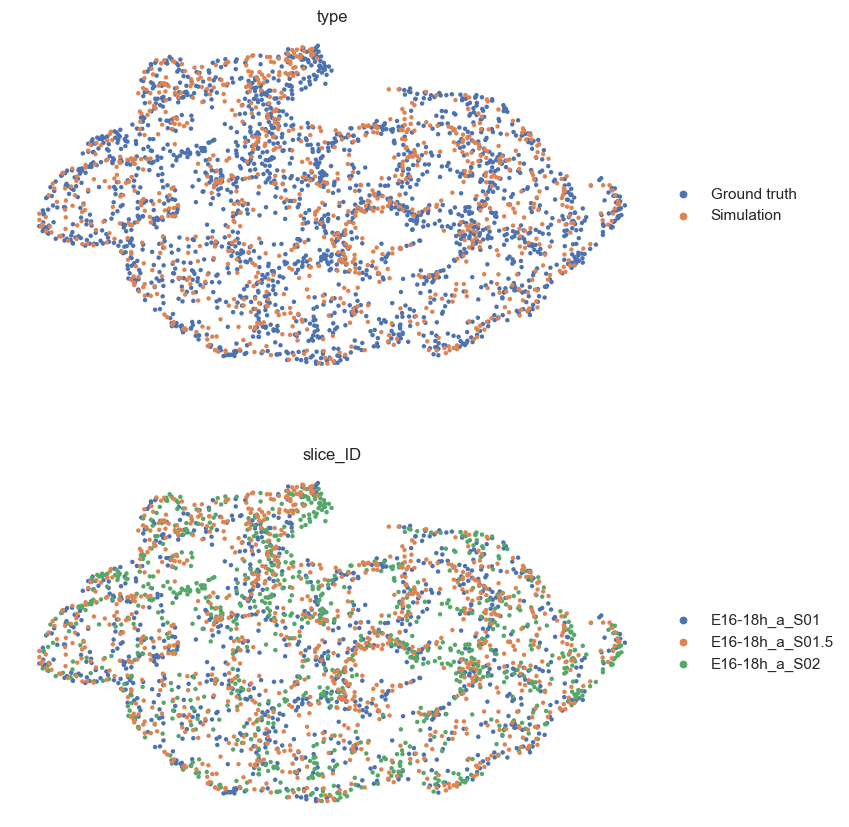

In [47]:
# umap embedding
sc.pp.neighbors(adata_comp, use_rep="X", n_neighbors=30)
sc.tl.umap(adata_comp, min_dist=0.5)
# plot umap
sc.pl.umap(adata_comp, color=["type", "slice_ID"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

In [52]:
# perform mclust
adata_comp.obsm["hidden_state"] = adata_comp.X
adata_comp = an.mclust_R(adata_comp, 10, use_rep="hidden_state", add_key="mclust", random_seed=2023)
sc.pl.umap(adata_comp, color=["mclust"], ncols=1, frameon=False, wspace=0.4, use_raw=False)

fitting ...
  |======================================================================| 100%


In [68]:
spatial1 = adata.obsm["spatial"][adata.obs["slice_ID"] == batch_name1][:, :2]
spatial2 = adata.obsm["spatial"][adata.obs["slice_ID"] == batch_name2][:, :2]
spatial_imputed = spatial1
adata_comp.obsm["spatial"] = np.concatenate([spatial1, spatial2, spatial_imputed], axis=0)


array([[-24.03857868,   2.16751269],
       [-24.03857868,   3.16751269],
       [-24.03857868,   4.16751269],
       ...,
       [ 22.96142132,   1.16751269],
       [ 23.96142132,  -2.83248731],
       [ 23.96142132,  -1.83248731]])

In [85]:
spatial1_new = adata.obsm["spatial_new"][adata.obs["slice_ID"] == batch_name1][:, :2]
spatial2_new = adata.obsm["spatial_new"][adata.obs["slice_ID"] == batch_name2][:, :2]
spatial_imputed_new = spatial1_new
adata_comp.obsm["spatial_new"] = np.concatenate([spatial1_new, spatial2_new, spatial_imputed_new], axis=0)

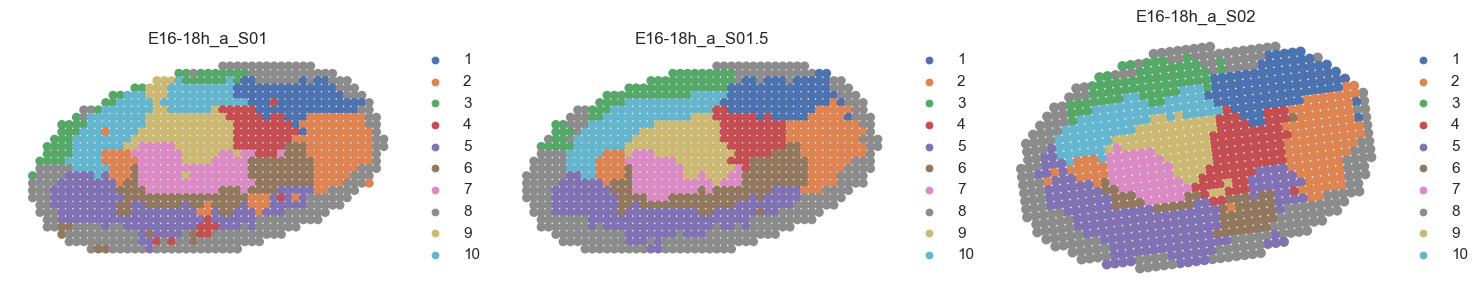

In [194]:
# plot spatial
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
for ind, batch_name in enumerate([batch_name1, batch_name1 + ".5", batch_name2]):
    sub_adata = adata_comp[adata_comp.obs["slice_ID"] == batch_name, :].copy()
    sc.pl.spatial(sub_adata, color=["mclust"], ncols=1, frameon=False,
                  spot_size=1.25, show=False, ax=axes[ind], colorbar_loc=None)
    axes[ind].set_title(batch_name)
plt.tight_layout()

In [73]:
def decode(model, hidden_states, edge_index):
    model.eval()
    with torch.no_grad():
        for layer in model.decoder:
            features = model._call_forward(layer, hidden_states, edge_index)
        for layer in model.out_gat:
            features = layer(features, edge_index)
    return features

In [ ]:
# decode the hidden states
hidden_states = torch.from_numpy(adata_comp.obsm["hidden_state"])
hidden_states = hidden_states.to(device)

In [76]:
used_batches = [batch_name1, batch_name2, batch_name1 + ".5"]
iter_comb = [(used_batches[i], used_batches[i+1]) for i in range(len(used_batches)-1)]
adata_comp = utils.cal_spatial_net3D(adata_comp, iter_comb=None, batch_id="slice_ID", rad_cutoff=1.4, z_k_cutoff=3,
                                add_key="spatial_net")

------Calculating spatial network for each batch...
Calculating spatial network for batch E16-18h_a_S01...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3790 edges, 985 cells, 3.8477 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S02...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3718 edges, 965 cells, 3.8528 neighbors per cell on average.
Calculating spatial network for batch E16-18h_a_S01.5...
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 3790 edges, 985 cells, 3.8477 neighbors per cell on average.
------Calculating spatial bipartite network...
------Spatial network calculated.


In [80]:
data = pipeline.prepare_dataset(adata_comp, use_net="spatial_net", use_spatial="spatial_new", device=device)


AnnData object with n_obs × n_vars = 2935 × 32
    obs: 'type', 'slice_ID', 'mclust'
    uns: 'neighbors', 'umap', 'type_colors', 'slice_ID_colors', 'mclust_colors', 'spatial_net'
    obsm: 'X_umap', 'hidden_state', 'spatial'
    obsp: 'distances', 'connectivities'

In [91]:
recon_exp = decode(spa_ae, data.x, data.edge_index).detach().cpu().numpy()

In [92]:
# compute spatial autocorrelation by scanpy
adata_comp_raw = sc.AnnData(recon_exp)
adata_comp_raw.obs["slice_ID"] = adata_comp.obs["slice_ID"]
adata_comp_raw.obsm["spatial"] = adata_comp.obsm["spatial"]
adata_comp_raw.obsm["spatial_new"] = adata_comp.obsm["spatial_new"]
adata_comp_raw.obsm["hidden_state"] = adata_comp.obsm["hidden_state"]
adata_comp_raw.var_names = adata.var_names

In [184]:
"CREG" in list(adata_comp_raw.var_names)
# TwdlX


True

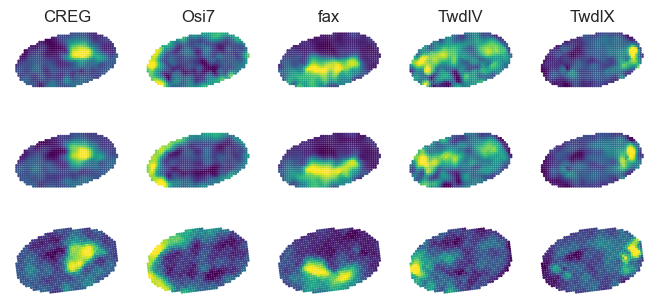

In [191]:
batch_names = [batch_name1, batch_name1 + ".5", batch_name2]
gene_names = ["CREG", "Osi7", "fax", "TwdlV", "TwdlX"]
fig, axes = plt.subplots(3, len(gene_names), figsize=(len(batch_names) * 2.25, 3.5))
for batch_name in batch_names:
    sub_adata = adata_comp_raw[adata_comp_raw.obs["slice_ID"] == batch_name, :].copy()
    for ind, gene_name in enumerate(gene_names):
        ax = axes[batch_names.index(batch_name)][ind]
        cax = sc.pl.spatial(sub_adata, color=[gene_name], frameon=False, colorbar_loc=None,
                      spot_size=1.25, show=False, ax=ax, color_map="viridis", vmin="p1", vmax="p99")
        if ind == 0:
            ax.set_ylabel(batch_name)
        else:
            ax.set_ylabel("")
        if batch_name == batch_names[0]:
            ax.set_title(gene_name)
        else:
            ax.set_title("")
plt.tight_layout()

In [124]:
cax

[<Axes: xlabel='spatial1'>]